# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2024-2025, Q4
* Course homepage: https://brightspace.tudelft.nl/d2l/home/682445
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Niels Stienen (N.L.Stienen@student.tudelft.nl)
* (c) TU Delft, 2025

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please **do not** delete it, instead run that cell as you would run all other cells. Finally, please **do not** add any extra cells to this notebook or change the existing cells unless you are explicitly asked to do so.

Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Mart Veldkamp"
STUDENT_1_STUDENT_NUMBER = "5885175"
STUDENT_1_NETID = "mmveldkamp"
STUDENT_1_EMAIL = "m.m.veldkamp@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions (also after the course is finished), and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. Please note that it is **not** allowed to post any code relating to solution attempts. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA or if not possible otherwise, send an email to the instructor or TA.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for you that you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. 

* Please note that the above mentioned _read-only_ protection only works in Jupyter Notebook, and it does not work if you open this notebook in another editor (e.g., VSCode, PyCharm, etc.). Therefore, we recommend that you only use Jupyter Notebook for this course. If you use any other editor, you may accidentally delete cells, modify the tests, etc., which would cause you to lose points.

* If you edit a function that is imported in another notebook, you need to **restart the kernel** of the notebook where you are using the function. Otherwise, the changes will not be effective.

* **IMPORTANT**: Please make sure that your code executes without any errors before submitting the notebook. An easy way to ensure this is to use the validation script as described in the README.

# Task 3f - Behaviour cloning of feedback torques as a function of the robot configuration (16.5p)
**Authors:** Giovanni Franzese, Lorenzo Lyons (L.Lyons@tudelft.nl), Maximilian Stölzle (M.W.Stolzle@tudelft.nl)

Here, we consider a dataset consisting of robot configurations (i.e., $\theta$) as the inputs and feedback torques (i.e., $\tau_{fb}$) as the labels. 
We will use a GP to regress the PD feedback torques as a function of the configurations and then use the trained GP to control the robot (in conjunction with the gravity compensation feedforward term).
Notice that we don't necessarily need to know that the dataset was collected from a PD controller; we know that the data are generated from a robot executing a certain behavior.

**Important note:** By definition, this model will be only an approximation of the actual feedback torques as the real PD policy also has access to the link velocities and the full reference trajectory specifications while the GP computes its prediction solely based on the current link angles.


In [4]:
import sys
# Had a problem with jax_double_pendulum not being found, so i had to add the path manually
sys.path.append("/home/murt/ics-pa-sv/")

In [5]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

# import all Python modules
from distutils.util import strtobool
from functools import partial
import gpytorch
from gpytorch.models import ApproximateGP
from IPython.display import display, HTML  # For animations in the notebook
import jax

jax.config.update("jax_platforms", "cpu")  # set default device to 'cpu'
jax.config.update("jax_enable_x64", True)  # double precision
from jax import Array, random
from jax import numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys
import torch
from torch.autograd.functional import jacobian
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

from jax_double_pendulum.dynamics import dynamical_matrices
from jax_double_pendulum.motion_planning import (
    generate_ellipse_trajectory,
    ELLIPSE_PARAMS,
)
from jax_double_pendulum.robot_simulation import simulate_robot
from jax_double_pendulum.robot_parameters import ROBOT_PARAMS
from jax_double_pendulum.utils import normalize_link_angles
from jax_double_pendulum.visualization import animate_robot

from utils import (
    generate_training_data,
    plot_data,
)

# define boolean to check if the notebook is run for autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))

# define folder where to save animations and plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)
# define the path to the folder that contains the datasets
datasets_dir = Path("datasets")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import the gravity compensation feedforward controller from Task 2a.2. **Make sure that you complete Task 2a first!**

In [6]:
# import the feedforward gravity compensation controller from problem_2/controllers.ipynb
sys.path.insert(0, Path.cwd().parent / "problem_2")
from ipynb.fs.full.controllers import ctrl_ff_gravity_compensation

# define simulation settings
# define time steps
sim_dt = 0.005
sim_duration = 6.0
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# generate reference trajectory
traj_ts = generate_ellipse_trajectory(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    **ELLIPSE_PARAMS,
)

# set the initial state to the start of the reference trajectory
th_0 = traj_ts["th_ts"][0]
th_d_0 = traj_ts["th_d_ts"][0]

## Task 3f.1 - Defining the GP model and setting up the training class (1p)

### Define a periodic kernel function with a period of $2 \pi$ (0.5p)
We work with a (double) pendulum and know that its configuration (i.e., $\theta$) is periodic with a period of $2 \pi$. Choosing a suitable kernel function will help the GP to model the data.
Don't forget to add a scale kernel before the periodic kernel and have it batch-independent like in the previous notebooks.

**Cheat sheet:**

Defining a periodic kernel that is periodic with a period of 2pi:
``` python 
PeriodicKernel(period_length_constraint=gpytorch.constraints.Interval(lower_bound=torch.tensor([2* torch.pi-0.01]), upper_bound=torch.tensor([2* torch.pi+0.01]), initial_value=torch.tensor([2* torch.pi]))) 
```

Printing the hyperparameters of a periodic kernel:
``` python
gp.covar_module.base_kernel.period_length
```

In [16]:
class MultitaskGPModel(ApproximateGP):
    def __init__(self, num_tasks, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_tasks])
        )

        variational_strategy = (
            gpytorch.variational.IndependentMultitaskVariationalStrategy(
                gpytorch.variational.VariationalStrategy(
                    self,
                    inducing_points,
                    variational_distribution,
                    learn_inducing_locations=True,
                ),
                num_tasks=num_tasks,
                task_dim=-1,
            )
        )

        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ZeroMean(batch_shape=torch.Size([num_tasks]))

        # self.covar_module = gpytorch.kernels.ScaleKernel(INSERT THE PERIODIC KERNEL HERE, batch_shape=torch.Size([num_tasks]))
        # YOUR CODE HERE
        periodic_kernel = gpytorch.kernels.PeriodicKernel(period_length_constraint=gpytorch.constraints.Interval(lower_bound=torch.tensor([2* torch.pi-0.01]), upper_bound=torch.tensor([2* torch.pi+0.01]), initial_value=torch.tensor([2* torch.pi])))
        
        self.covar_module = gpytorch.kernels.ScaleKernel(
            base_kernel=periodic_kernel,
            batch_shape=torch.Size([num_tasks])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Define the GP and the likelihood inside the `ControllerModel` class (0.5p)

In [17]:
class ControllerModel:
    def __init__(self, X, Y, n_ind=100, batch_size=256):
        self.X = X
        self.Y = Y
        self.input_features = X.shape[1]
        self.output_dim = Y.shape[1]
        # number of inducing points
        unique_random_indices = torch.randperm(len(X))[:n_ind]
        inducing_points = X[unique_random_indices]
        self.inducing_points = inducing_points
        self.batch_size = batch_size
        self.is_cuda = False

        # self.gp =
        # self.likelihood =
        # YOUR CODE HERE
        self.gp = MultitaskGPModel(num_tasks=self.output_dim, inducing_points=inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=self.output_dim)
 
    def to_cuda(self):
        if torch.cuda.is_available():
            self.gp = self.gp.cuda()
            self.likelihood = self.likelihood.cuda()
            self.X = self.X.cuda()
            self.Y = self.Y.cuda()
            self.is_cuda = True
        else:
            raise EnvironmentError("Cuda not available")

    def predict(self, x):
        if self.is_cuda:
            x = x.cuda()
        return self.likelihood(self.gp(x))

    def variance(self, x):
        predictions = self.gp(x)
        return predictions.variance

    def derivative_variance(self, x):
        if self.is_cuda:
            x = x.cuda()
        jac = (
            jacobian(self.variance, x)
            .detach()[0]
            .view(self.output_dim, self.input_features)
        )  # shape: (num_outputs, num_features)
        return jac

    def train(self, num_epochs=400):
        self.gp = self.gp.double()
        self.likelihood = self.likelihood.double()
        self.X = self.X.double()
        self.Y = self.Y.double()
        self.train_dataset = TensorDataset(self.X, self.Y)
        self.train_loader = DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True
        )
        self.gp.train()
        self.likelihood.train()

        optimizer = torch.optim.Adam(
            [
                {"params": self.gp.parameters()},
                {"params": self.likelihood.parameters()},
            ],
            lr=0.01,
        )

        # Our loss object. We're using the VariationalELBO
        self.mll = gpytorch.mlls.VariationalELBO(
            self.likelihood, self.gp, num_data=self.Y.size(0)
        )

        # to plot the loss function
        self.elbo_loss_vec = np.zeros(num_epochs)

        for i in tqdm(range(num_epochs)):
            for x_batch, y_batch in self.train_loader:
                optimizer.zero_grad()
                output = self.gp(x_batch)
                loss = -self.mll(output, y_batch)
                loss.backward()
                optimizer.step()

            loss_dataset = -self.mll(self.gp(self.X), self.Y)
            self.elbo_loss_vec[i] = loss_dataset



    def plot_convergence(self, experiment_name: str):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(self.elbo_loss_vec, label="loss")
        ax.set_xlabel("Epochs")
        ax.set_ylabel(r" Negative Lower Bound of Marginal Log Likelihood$")
        plt.savefig(str(outputs_dir / experiment_name))

## Task 3f.2 - Load the trajectory-following dataset (0p)
Here, we load the dataset recorded in Task 3c.3. Namely, we extract the torques generated by the PD feedback controller when tracking the ellipse reference trajectory in conjunction with a gravity compensation feedforward term.

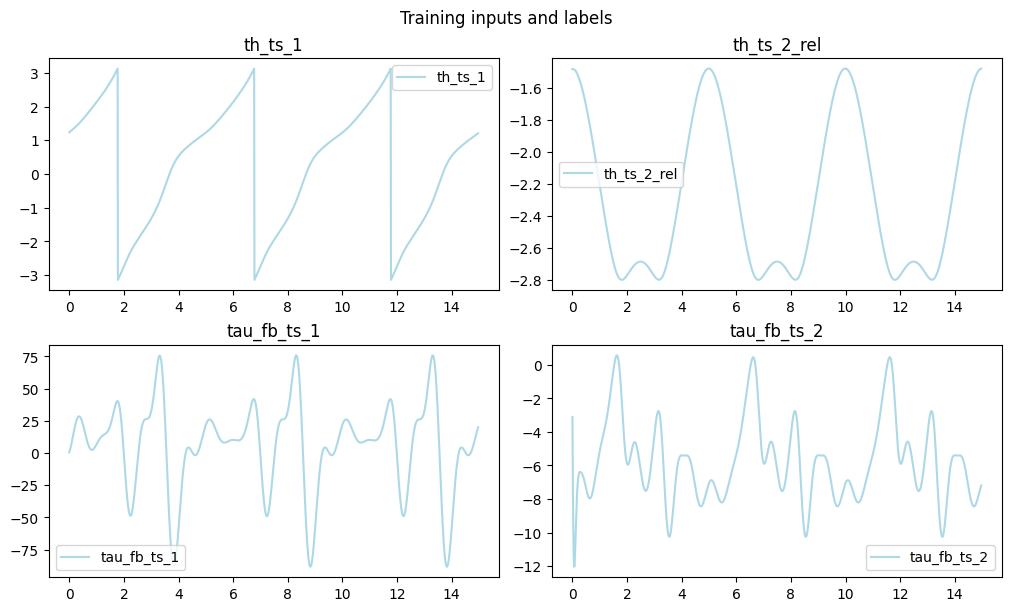

In [18]:
dataset_name = "trajectory_high_gains_grav_comp"
df = pd.read_csv(datasets_dir / f"{dataset_name}.csv")

input_columns = ["th_ts_1", "th_ts_2_rel"]
output_columns = ["tau_fb_ts_1", "tau_fb_ts_2"]

# plot the training data
plot_data(
    df,
    input_columns,
    output_columns,
    filepath=str(outputs_dir / f"task_3f-2_dataset_plot_{dataset_name}.pdf"),
)

# assemble tensors for training
X, Y = generate_training_data(df, input_columns, output_columns)

## Task 3f.3 - Initialize the `ControllerModel` and train the GP (0.5p)

  0%|          | 0/400 [00:00<?, ?it/s]

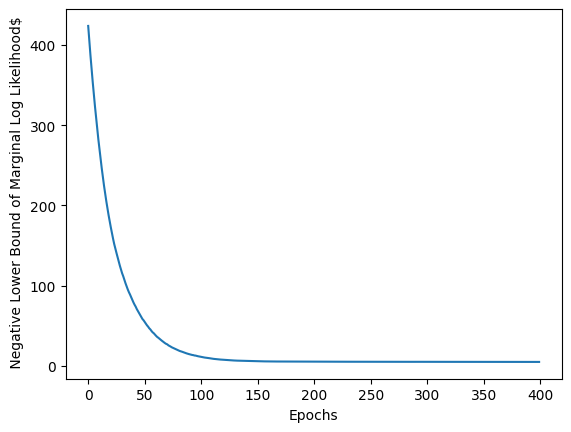

In [20]:
# set random seed
torch.manual_seed(42)

# controller_model =
# YOUR CODE HERE
controller_model = ControllerModel(X, Y)
controller_model.train()

# plot convergence of training loss
controller_model.plot_convergence(
    f"task_3f-3_training_convergence_feedback_torques_configuration_input.pdf"
)

## Task 3f.4 - Analyse the trained GP and visualize the control policy (5p)
### Period length of kernel (1p)
Print the period length of the kernel and verify that it is close to $2 \pi$.

In [21]:
# print(PERIOD_LENGTH_OF_KERNEL)
# YOUR CODE HERE
print("Period length of the periodic kernel:")
print(controller_model.gp.covar_module.base_kernel.period_length)

Period length of the periodic kernel:
tensor([[6.2800]], dtype=torch.float64, grad_fn=<AddBackward0>)


### Surface plot of GP-based control policy (1p)
Visualize the predicted torque for each link as a function of the configuration.

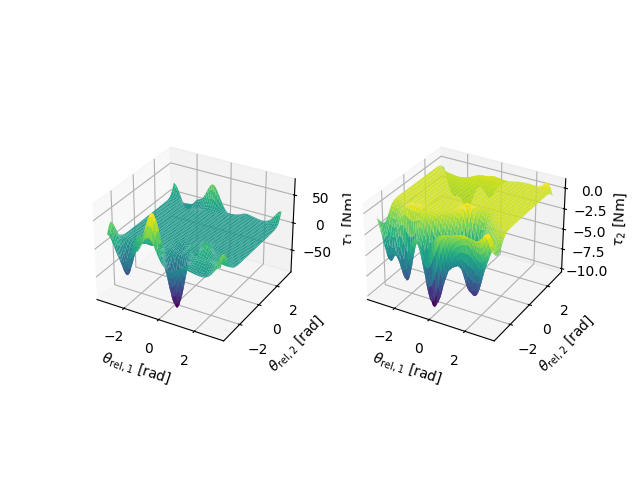

In [22]:
# plot controller action as a function of inputs
%matplotlib widget

# define input ranges
theta_1_range = np.linspace(-np.pi, np.pi, 100)
theta_2_range = np.linspace(-np.pi, np.pi, 100)

# Create a grid of input points for prediction
theta_1_grid, theta_2_grid = np.meshgrid(theta_1_range, theta_2_range)

# create input points
input_points = np.column_stack((theta_1_grid.flatten(), theta_2_grid.flatten()))

# define test inputs
X_test = torch.tensor(input_points, dtype=torch.float32)
# generate predictions on test inputs

with torch.no_grad():
    # extract torque predictions for the first and second link, respectively
    # Y_pred =
    # Y_pred_mean_grid_1 =
    # Y_pred_mean_grid_2 =
    # YOUR CODE HERE
    Y_pred = controller_model.predict(X_test)

    # Extract predicted means for each task (joint torque)
    Y_pred_mean_grid_1 = Y_pred.mean[:, 0].view(100, 100).cpu().numpy()
    Y_pred_mean_grid_2 = Y_pred.mean[:, 1].view(100, 100).cpu().numpy()

# Create a 3D surface plot
fig = plt.figure(num="Configuration vs. cloned feedback torques")
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(theta_1_grid, theta_2_grid, Y_pred_mean_grid_1, cmap="viridis")
# Set axis labels
ax.set_xlabel(r"$\theta_{\mathrm{rel},1}$ [rad]")
ax.set_ylabel(r"$\theta_{\mathrm{rel},2}$ [rad]")
ax.set_zlabel(r"$\tau_1$ [Nm]")

ax = fig.add_subplot(122, projection="3d")
ax.plot_surface(theta_1_grid, theta_2_grid, Y_pred_mean_grid_2, cmap="viridis")
# Set axis labels
ax.set_xlabel(r"$\theta_{\mathrm{rel},1}$ [rad]")
ax.set_ylabel(r"$\theta_{\mathrm{rel},2}$ [rad]")
ax.set_zlabel(r"$\tau_2$ [Nm]")

# save figure
plt.savefig(str(outputs_dir / "task_3f-4_surface_plot_gp_feedback_torque_policy.pdf"))

### Can you identify the effect of the periodic kernel in the surface plot? (2p)

### Surface plot of GP uncertainty (standard deviation)(1p)
Visualize the predicted uncertainties for the torque on each link as a function of the configuration.

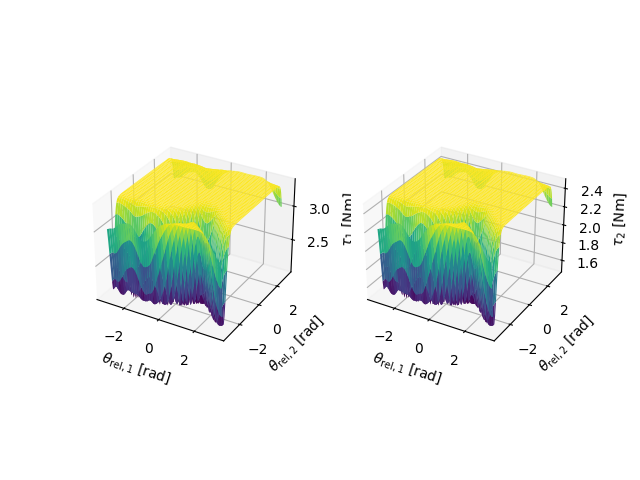

In [23]:
%matplotlib widget
with torch.no_grad():
    # Y_pred_std_grid_1 =
    # Y_pred_std_grid_2 =
    # YOUR CODE HERE
    Y_pred = controller_model.predict(X_test)
    Y_pred_std_grid_1 = Y_pred.stddev[:, 0].view(100, 100).cpu().numpy()
    Y_pred_std_grid_2 = Y_pred.stddev[:, 1].view(100, 100).cpu().numpy()

# Create a 3D surface plot
fig = plt.figure(num="Configuration vs. uncertainty on feedback torques")
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(theta_1_grid, theta_2_grid, Y_pred_std_grid_1, cmap="viridis")
# Set axis labels
ax.set_xlabel(r"$\theta_{\mathrm{rel},1}$ [rad]")
ax.set_ylabel(r"$\theta_{\mathrm{rel},2}$ [rad]")
ax.set_zlabel(r"$\tau_1$ [Nm]")

ax = fig.add_subplot(122, projection="3d")
ax.plot_surface(theta_1_grid, theta_2_grid, Y_pred_std_grid_2, cmap="viridis")
# Set axis labels
ax.set_xlabel(r"$\theta_{\mathrm{rel},1}$ [rad]")
ax.set_ylabel(r"$\theta_{\mathrm{rel},2}$ [rad]")
ax.set_zlabel(r"$\tau_2$ [Nm]")

# save figure
plt.savefig(
    str(outputs_dir / "task_3f-4_surface_plot_gp_feedback_torque_uncertainty.pdf")
)

## Task 3f.5 - Control the robot using the GP-based policy as the controller (3p)
### Define the feedback control function (1p)
Use the mean of the GP predictions as the feedback controller. Leverage gravity compensation as the feedforward term.

In [26]:
# run the simulation with cloned PD controller

# define feedforward gravity compensation controller
ctrl_ff = partial(
    ctrl_ff_gravity_compensation, partial(dynamical_matrices, ROBOT_PARAMS)
)


# define the feedback function that implements the GP-based controller
def ctrl_fb(th: Array, th_d: Array, th_des: Array, th_d_des: Array) -> Array:
    """
    Feedback controller that leverages the GP to compute the control action cloning the behavior of the PD controller
    Args:
        th: link angles. Shape: (2,)
        th_d: link velocities. Shape: (2,)
        th_des: desired link angles. Shape: (2,)
        th_d_des: desired link velocities. Shape: (2,)
    Returns:
        tau_gp: link torques computed by the GP-based controller. Shape: (2,)
    """
    # compute the normalized joint angles (i.e., relative angles) from the link angles
    th_rel = normalize_link_angles(jnp.array([th[0], th[1] - th[0]]))

    # construct input for GP
    gp_input = torch.tensor(np.array(th_rel)).unsqueeze(0)

    with torch.no_grad():
        # evaluate GP output and use the mean as the controller action
        # gp_output=
        # tau_gp =
        # YOUR CODE HERE
        gp_output = controller_model.predict(gp_input)
        tau_gp = gp_output.mean.squeeze()


    tau_gp= tau_gp.numpy().flatten()    
    return tau_gp


# set the initial state to the start of the reference trajectory
th_0 = traj_ts["th_ts"][0]
th_d_0 = traj_ts["th_d_ts"][0]

# simulate the robot together in closed loop with the GP-based controller
print("starting simulation")
sim_ts = simulate_robot(
    ROBOT_PARAMS,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=th_d_0,
    ctrl_ff=ctrl_ff,
    ctrl_fb=ctrl_fb,
    jit_compile=False,
)
print("finished simulation")

if not AUTOGRADING:
    print("producing animation")
    ani = animate_robot(
        ROBOT_PARAMS,
        traj_ts=traj_ts,
        sim_ts=sim_ts,
        step_skip=5,
        show=False,
        filepath=str(
            outputs_dir
            / "task_3f-5_robot_animation_behavioural_cloning_feedback_torques_configuration_input.mp4"
        ),
    )
    display(HTML(ani.to_html5_video()))

starting simulation
finished simulation
producing animation


### Discuss the behavior of the closed-loop system (2p)
The actual trajectory will quickly diverge from the reference trajectory. Why?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Task 3f.6 - Control the robot using the GP-based policy as the feedback controller while penalizing uncertainty (7p)

### Tutorial on uncertainty derivation (0p)

In [27]:
gp_input = torch.zeros(1, 2).unsqueeze(0)
mean = controller_model.predict(gp_input).mean
print("Mean", mean)
variance = controller_model.predict(gp_input).variance
print("Variance", variance)
Jac = controller_model.derivative_variance(gp_input)
print("Jacobian", Jac)

Mean tensor([[0.0028, 0.0006]], dtype=torch.float64, grad_fn=<ViewBackward0>)
Variance tensor([[11.3414,  6.1534]], dtype=torch.float64, grad_fn=<ViewBackward0>)
Jacobian tensor([[-7.7926e-07,  9.3155e-07],
        [-4.3959e-07,  5.3405e-07]])


As you can see, the derivative of the variance is a matrix of dimension num_output x num_input. This is because the GP predicts `num_output` uncertainties, one for each output dimension. We have two output dimensions in our case, so the matrix is 2xnum_input. Hence, we can define it as: 
$$ J= 
\begin{bmatrix}
\frac{\partial \sigma_{\tau_1}}{\partial q_1} & \frac{\partial \sigma_{\tau_1}}{\partial q_2} \\
\frac{\partial \sigma_{\tau_2}}{\partial q_1} & \frac{\partial \sigma_{\tau_2}}{\partial q_2}\\
\end{bmatrix} = 
\begin{bmatrix}
    \nabla \sigma_{\tau_1} \\
    \nabla \sigma_{\tau_2} \\
\end{bmatrix}$$

### Define the feedback control function that includes a variance minimization term (5p)

In order to increase the performance of the learned control behavior, we will add another force field that pushes in the direction of minimizing the predicted epistemic uncertainty, i.e., the variance of the GP prediction. We also add a small dissipation term.

For this, you need to:

1. Extract the mean and standard deviation of the GP predictions
2. Compute the gradient of the variance of the GP prediction with respect to the input $\nabla \sigma_\mathrm{GP}$ (check the `ControllerModel` class to pick the right method; do not implement it yourself).
3. Implement the control law that repels the system away from uncertainty. It should take the form $\tau_{\mathrm{var,repell}} = - k_\mathrm{var} \: \sigma_\mathrm{GP} \: \mathrm{sign}(\nabla \sigma_\mathrm{GP})$.
5. Tune the proportional gain that multiplies the gradient term, i.e., `k_var`. 

Please refer to the tutorial on uncertainty derivation above. Since both the uncertainties will decrease in the same direction and we are only interested in the sign of the gradient, in the next code, you can simply select the first or the second row of the Jacobian matrix.

In [28]:
# simulate with the cloned PD controller, including a variance-repelling term

# define feedforward gravity compensation controller
ctrl_ff = partial(
    ctrl_ff_gravity_compensation, partial(dynamical_matrices, ROBOT_PARAMS)
)


# define the feedback function that implements the GP-based controller
def ctrl_fb(th: Array, th_d: Array, th_des: Array, th_d_des: Array) -> Array:
    """
    Feedback controller that leverages the GP to compute the control action cloning the behavior of the PD controller
    Args:
        th: link angles. Shape: (2,)
        th_d: link velocities. Shape: (2,)
        th_des: desired link angles. Shape: (2,)
        th_d_des: desired link velocities. Shape: (2,)
    Returns:
        tau_fb: link torques computed by the GP-based feedback controller. Shape: (2,)
    """
    # compute the normalized joint angles (i.e., relative angles) from the link angles
    th_rel = normalize_link_angles(jnp.array([th[0], th[1] - th[0]]))

    # construct input for GP
    gp_input = torch.tensor(np.array(th_rel)).unsqueeze(0)

    with torch.no_grad():
        # perform the prediction with the GP
        # gp_output =
        # tau_gp_mean =
        # tau_gp_sigma =
        # YOUR CODE HERE
        gp_output = controller_model.predict(gp_input)
        tau_gp_mean = gp_output.mean.squeeze()     # (2,)
        tau_gp_sigma = gp_output.stddev.squeeze()  # (2,)

    # derive the gradient of the variance
    # select only the first or the second row of the Jacobian!!
    # grad_gp_var =
    # YOUR CODE HERE
    # Compute gradient of variance
    jac = controller_model.derivative_variance(gp_input)  # shape: (2, 2)

    # Use just the first task (or second) for directional repulsion
    grad_gp_var = jac[0]  # shape: (2,)
    
    # implement the control policy component that repels the system away from uncertainty
    # proportional to k_var, tau_gp_sigma, and grad_gp_var
    # k_var =
    # tau_var_repel =
    # Hint: k_var should be in the range [0, 20]
    # YOUR CODE HERE
    # Repelling torque: negative sign pushes away from uncertain directions
    k_var = 10.0  # ← tunable gain
    tau_var_repel = -k_var * tau_gp_sigma[0] * torch.sign(grad_gp_var)

    # compute the total feedback torque
    tau_fb = tau_gp_mean + tau_var_repel

    return tau_fb.squeeze().numpy()



# set the initial state to the start of the reference trajectory
th_0 = traj_ts["th_ts"][0]
th_d_0 = traj_ts["th_d_ts"][0]


# simulate the robot together in a closed loop with the GP-based controller
print("starting simulation")
sim_ts = simulate_robot(
    ROBOT_PARAMS,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=th_d_0,
    ctrl_ff=ctrl_ff,
    ctrl_fb=ctrl_fb,
    jit_compile=False,
)
print("finished simulation")

if not AUTOGRADING:
    print("producing animation")
    ani = animate_robot(
        ROBOT_PARAMS,
        traj_ts=traj_ts,
        sim_ts=sim_ts,
        step_skip=5,
        show=False,
        filepath=str(
            outputs_dir
            / "task_3f-6_robot_animation_behavioural_cloning_feedback_torques_variance_minimization.mp4"
        ),
    )
    display(HTML(ani.to_html5_video()))

starting simulation
finished simulation
producing animation


### Discuss the behavior of the closed-loop system (2p)
It looks like the performance improved a lot. Why? Explain! You can also use plots to motivate your theory. Feel free also to change the control parameters to validate your reasoning.

In [1]:
#YOUR ASNWER HERE
#### Answer

# The performance improved significantly because the controller now actively avoids regions of high epistemic 
# uncertainty in the learned GP model. This is achieved by adding a repelling torque that pushes the system toward 
# parts of the state space where the GP is more confident (i.e., where it has seen training data).

# Without this term, the GP controller may produce unreliable torques in unseen or poorly modeled regions, 
# which can lead to instability or degraded tracking. By including the gradient of the variance, the controller 
# shapes the trajectory not just toward the task goal, but also through areas where the model is trustworthy.